<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderKaggle_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [2]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

**Tras relizar algunas configuraciones descargamos el dataset:**

In [8]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.50G/9.51G [00:57<00:00, 191MB/s]
100% 9.51G/9.51G [00:57<00:00, 177MB/s]
CPU times: user 888 ms, sys: 172 ms, total: 1.06 s
Wall time: 59.1 s


In [9]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [3]:
datasetKaggle = 'datasetKaggle'

In [4]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [5]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/2b07790a2422.png'

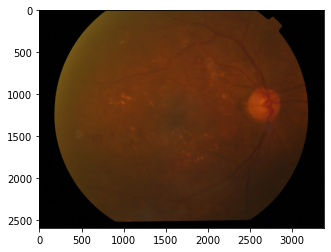

In [6]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [7]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [8]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [14]:
df_trainKaggle.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [17]:
# !wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
# !wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
# !wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [18]:
# !rm -rvf Training_Set_Pre
# !unzip -qq train.zip #-qq no verbose
# !unzip -qq test.zip
# !unzip -qq val.zip

Descargamos el dataset sin procesar, para aplicar el mismo procesado a los dos datsets

In [19]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-24 15:14:05 URL:https://uc01bd1f6a31485fc46d7d1b8ee6.dl.dropboxusercontent.com/cd/0/inline2/Bn1v3dyI-OJqj3m4NC4OkTurz2jsEloAr80O0yR_OJDRSB1OtAO0gdzArzYb1vWNpCaYmDKSdCWN3NqGRKJOggqrckdKUGUHb-fVou9qYlhTzMJQGytMx2qbxVx_wxULZAe6xZWmLIGikdZtNUPNUB3imwxrcZSG6AxnEc-3xmTBnSyTvUAY-FytuI729-TMWlMfP2AcEF1uY6VFOtquHVVMTZWDCJ6yJcSYe7N7aXHcifVw135hdFlnUagI_FpkIHGIYCTKayrfopYnjHNuV5cqAY8TstP_OIPTn9Qz2QaT9UQ8OHUJ6O8KSgiTjYKD5UzqXO9Hvqaxp3diKOrtgoxS2fI23jCQW05BPmAhV83QhE1JddlABvctGx6yfvEgse0rD20YsuQM0ulWFqhjLMHulz5xp6roW3OG2QzIkADzHg/file [144922725/144922725] -> "datasetComp.zip" [1]


In [20]:
!unzip -qq datasetComp.zip

In [21]:
# trainPath = 'Training_Set_Pre/'
# testPath  = 'Test_Set_Pre/'
# valPath  =  'Evaluation_Set_Pre/'

In [9]:
trainPath = 'Training_Set_C/'
testPath  = 'Test_Set_C/'
valPath  =  'Evaluation_Set_C/'

## Preparación de Datos

In [10]:
IMG_SIZE = 256

### Funciones de procesado

In [11]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

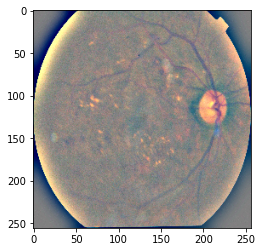

In [12]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0])
plt.imshow(img)

### Datos Kaggle

In [13]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    # image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      image = load_ben_color(pathO + '/' + str(id) + '.png')
      normal.append(np.asarray(image))
    # else:
    #   enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [14]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [15]:
normalKaggle.shape

(1805, 256, 256, 3)

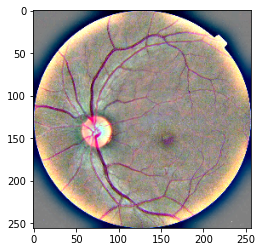

In [16]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [17]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = load_ben_color(pathO + '/' + str(id) + '.png')
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [18]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [19]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [20]:
normalTrain.shape

(401, 256, 256, 3)

In [21]:
normalTest.shape

(134, 256, 256, 3)

Ya la tenemos reescalada a la medida deseada:

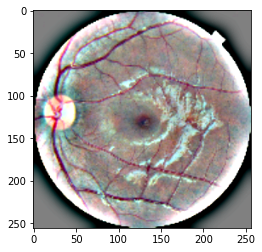

In [22]:
plt.imshow(normalTrain[0])

## Autoencoder Mas complejo

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

In [78]:
# Create the Encoder and Decoder
#pass the gray scale input image of size(28,28,1)
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)


#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [79]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [80]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [81]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 256, 256, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 256, 256, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 128, 64)      18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 128, 128, 64)     256       
 tion)                                                     

In [82]:
normalKaggle.shape

(1805, 256, 256, 3)

In [84]:
hist=autoencoder.fit(normalKaggle, normalKaggle,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(normalTest, normalTest)
                )

Epoch 1/50
15/15 [==============================] - 14s 940ms/step - loss: -1124.1195 - val_loss: -6917.7690
Epoch 2/50
15/15 [==============================] - 15s 977ms/step - loss: -1346.6981 - val_loss: -6884.3013
Epoch 3/50
15/15 [==============================] - 15s 990ms/step - loss: -1583.2943 - val_loss: -7043.4414
Epoch 4/50
15/15 [==============================] - 14s 956ms/step - loss: -1830.3055 - val_loss: -7957.6670
Epoch 5/50
15/15 [==============================] - 14s 936ms/step - loss: -2092.0117 - val_loss: -8395.8096
Epoch 6/50
15/15 [==============================] - 14s 933ms/step - loss: -2364.1899 - val_loss: -7219.0210
Epoch 7/50
15/15 [==============================] - 14s 943ms/step - loss: -2645.5493 - val_loss: -8246.2783
Epoch 8/50
15/15 [==============================] - 15s 974ms/step - loss: -2936.1855 - val_loss: -8019.4336
Epoch 9/50
15/15 [==============================] - 14s 959ms/step - loss: -3237.9443 - val_loss: -8317.0146
Epoch 10/50
15/15 [

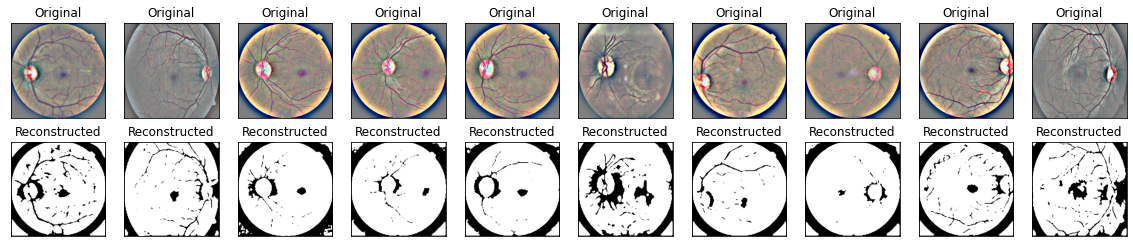

In [85]:
decoded_imgs = autoencoder.predict(normalKaggle)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(normalKaggle[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

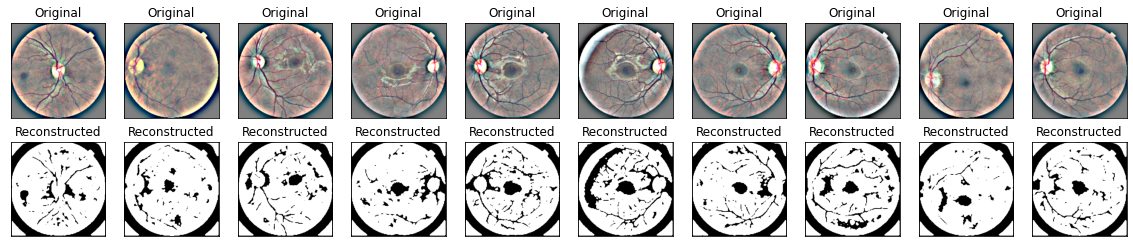

In [86]:
decoded_imgs = autoencoder.predict(normalTest)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

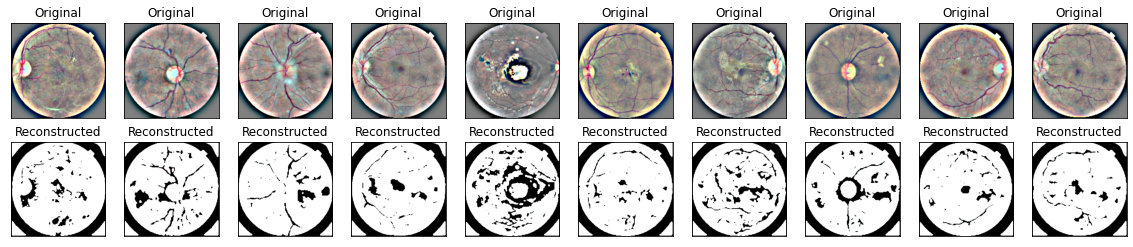

In [87]:
decoded_imgs = autoencoder.predict(enfermedadTest)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(enfermedadTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()